### Learn trajectories using Newtonian dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow import keras

### Create data

In [2]:
in_size = 25
epochs = 10000
w_o = 1
g_o = 0.1

# data 2nd order ode
def system(t,u):
    x , y = u
    x_dot = y
    y_dot = -w_o**2*x-g_o*y
    return [x_dot , y_dot]

u0 = [0,1]
t_span = (0,12)
t_eval = np.linspace(0.1,12,in_size)

sol = solve_ivp(system , t_span , u0 , t_eval = t_eval , method = 'RK45')

t = sol.t.reshape(-1,1).astype(np.float32)
x = sol.y[0].reshape(-1,1).astype(np.float32)


u0_test = [0,1]
t_span_test = (0,20)
t_eval_test = np.linspace(0.1,20,200)

sol_test = solve_ivp(system , t_span_test , u0_test , t_eval = t_eval_test , method = 'RK45')

t_test = t_eval_test.reshape(-1,1).astype(np.float32)
x_test = sol_test.y[0].reshape(-1,1).astype(np.float32)
t_test.size , x_test.size

(200, 200)

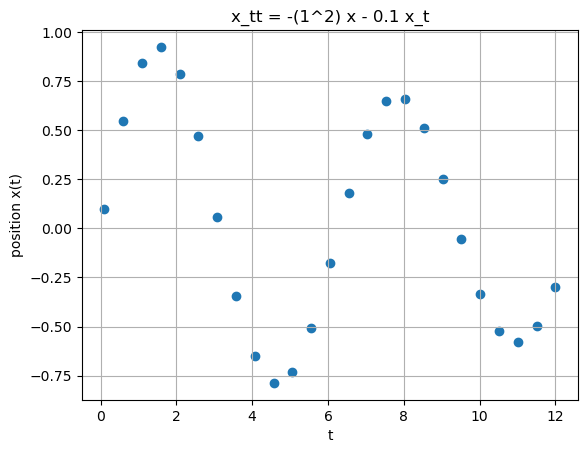

In [3]:
plt.scatter(t,x)
plt.grid()
plt.xlabel('t')
plt.ylabel('position x(t)')
plt.title(f'x_tt = -({w_o}^2) x - {g_o} x_t')
plt.show()

#### Naive simple neural net

In [4]:
naive = keras.Sequential([
    keras.layers.Input(shape = (1,)),
    keras.layers.Dense(5,activation = 'relu'),
    keras.layers.Dense(1,activation = 'linear')
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
naive.compile(loss = 'mean_squared_error' , optimizer = optimizer)
naive.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# training
history_naive = naive.fit(t, x, epochs = epochs, batch_size = 1 , verbose = 0)

In [6]:
#t_test = np.linspace(0,15,100)
x_naive = naive(t_test).numpy().flatten()

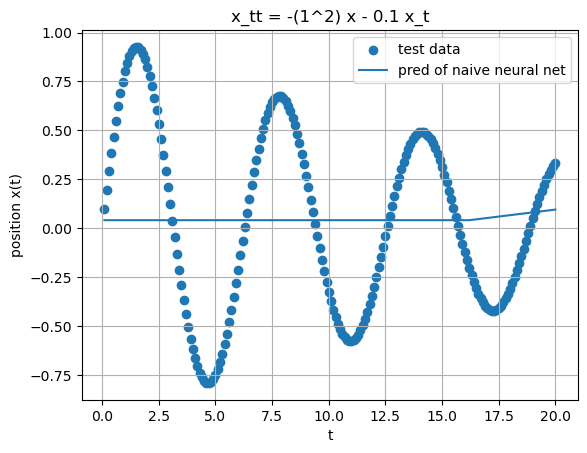

In [7]:
plt.scatter(t_test,x_test , label = 'test data')
plt.plot(t_test, x_naive , label = 'pred of naive neural net')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('position x(t)')
plt.title(f'x_tt = -({w_o}^2) x - {g_o} x_t')
plt.show()

#### Snake activation function

In [8]:
def snake(x):
    return x+tf.sin(x)**2

In [9]:
snake_net = keras.Sequential([
    keras.layers.Input(shape = (1,)),
    keras.layers.Dense(5,activation = snake),
    keras.layers.Dense(1,activation = 'linear')
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
snake_net.compile(loss = 'mean_squared_error' , optimizer = optimizer)
snake_net.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# training
history_snake = snake_net.fit(t, x, epochs = epochs, batch_size = 1 , verbose = 0)

In [11]:
x_snake = snake_net(t_test).numpy().flatten()

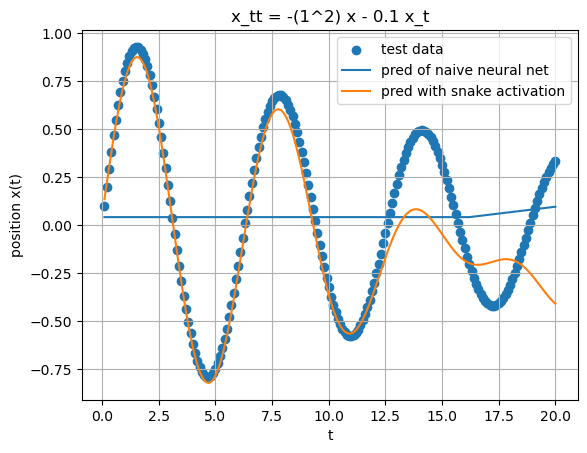

In [12]:
plt.scatter(t_test,x_test , label = 'test data')
plt.plot(t_test, x_naive , label = 'pred of naive neural net')
plt.plot(t_test , x_snake , label = 'pred with snake activation')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('position x(t)')
plt.title(f'x_tt = -({w_o}^2) x - {g_o} x_t')
plt.show()

### -> Physics informed

#### Training and loss functions definitions 

In [13]:
def pinn_loss(model, t , pars):

    with tf.GradientTape() as tape2:
        tape2.watch(t)  # Ensure t is being tracked for differentiation
        with tf.GradientTape() as tape1:
            tape1.watch(t)
            x = model(t)  
        x_dot = tape1.gradient(x, t)
    x_dot_dot = tape2.gradient(x_dot, t)

    ode = x_dot_dot + pars[0]**2*x+ pars[1]*x_dot            # define ode as f(t , x , x_dot , x_dot_dot) = 0
    
    # Return the mean squared error of the residual
    return tf.reduce_mean(tf.square(ode))

In [14]:
def combined_loss(model, t_train , t_val, x_true, pars ,weight = 0.5):

    x_pred = model(t_train)
    data_loss = tf.reduce_mean(tf.square(x_true - x_pred))
    
    # Physics loss computed on the same t
    phys_loss = pinn_loss(model, t_val , pars)
    
    return (1-weight) * data_loss + weight * phys_loss

In [15]:
def train_step(model , t, t_val, x_true , pars , weight = 0.5):
    with tf.GradientTape() as tape:
        
        loss_value = combined_loss(model, t , t_val, x_true , pars , weight = weight)

    variables = model.trainable_variables + pars
    gradients = tape.gradient(loss_value, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss_value

In [16]:
def train(model , t_train , t_val , x_train , pars , epochs , weight = 0.5):
    # training loop
    history = []
    for epoch in range(epochs):
        t_tensor = tf.convert_to_tensor(t_train)  # ensure t has gradient tracking
        t_val_tr = tf.convert_to_tensor(t_val)
        loss_val = train_step(model , t_tensor , t_val_tr, x_train , pars  , weight)
        history.append(loss_val)
    history = np.array(history)
    return history

#### Physics informed neural net

In [17]:
pi_net = keras.Sequential([
    keras.layers.Input(shape = (1,)),
    keras.layers.Dense(5,activation = snake),
    keras.layers.Dense(1,activation = 'linear')
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)# , clipnorm=1.0)
pi_net.compile(loss = 'mean_squared_error' , optimizer = optimizer)
pi_net.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
w = tf.Variable(1.0, trainable=True, dtype=tf.float32, name="w")
g = tf.Variable(0.1, trainable=True, dtype=tf.float32, name="g") # parameters of ode 

# parameters should be a tf.Variable object

pars = [w , g]
history_pi = train(pi_net , t , t , x , pars ,epochs = epochs , weight = 0.7) 

In [19]:
x_pi = pi_net(t_test).numpy().flatten()

In [20]:
w.numpy() , g.numpy()

(0.99515986, 0.092358716)

#### Ode solver

In [21]:
ode_net = keras.Sequential([
    keras.layers.Input(shape = (1,)),
    keras.layers.Dense(5,activation = snake),
    keras.layers.Dense(1,activation = 'linear')
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
ode_net.compile(loss = 'mean_squared_error' , optimizer = optimizer)
ode_net.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
x_ode , t_ode , t_val = x[:2] , t[:2] , t[2:]

In [23]:
w2 = tf.Variable(1.0, trainable=False, dtype=tf.float32, name="w2")
g2 = tf.Variable(0.1, trainable=False, dtype=tf.float32, name="g2") # parameters of ode (Non trainable)

# parameters should be a tf.Variable object

pars = [w2 , g2]

history_ode = train(ode_net , t_ode , t_val , x_ode , pars , epochs = epochs, weight = 0.7)
x_ode_hat = ode_net(t_test).numpy().flatten()

/Users/User/.local/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['w2:0', 'g2:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


In [24]:
ode_net.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55 (224.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39 (160.00 B)

_____________________________________________________________________________________________________________________________________________
### Results 

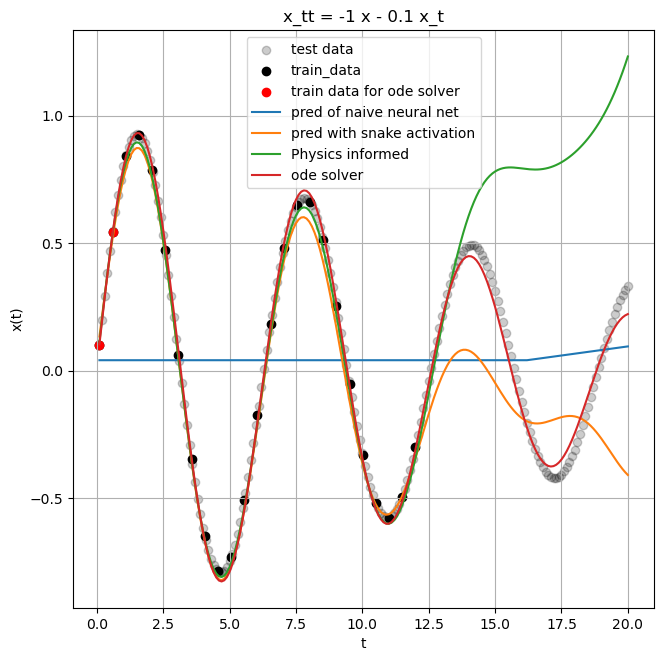

In [25]:
plt.figure(figsize = (7.5,7.5))

plt.scatter(t_test,x_test , label = 'test data' , c = 'k' , alpha = 0.2)
plt.scatter(t,x,label = 'train_data' , c = 'k' , alpha = 1)
plt.scatter(t_ode, x_ode,label = 'train data for ode solver' , c = 'red')
plt.plot(t_test , x_naive , label = 'pred of naive neural net')
plt.plot(t_test , x_snake , label = 'pred with snake activation')
plt.plot(t_test , x_pi , label = 'Physics informed')
plt.plot(t_test , x_ode_hat , label = 'ode solver')

plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title(f'x_tt = -{w_o**2} x - {g_o} x_t')
plt.show()

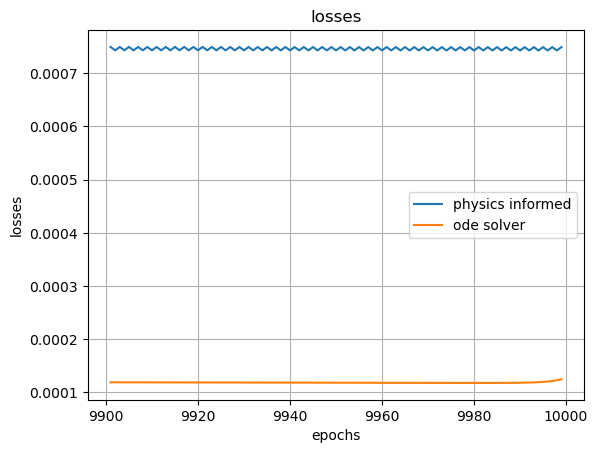

In [37]:
final_points = 9900
eps = np.linspace(0,epochs,epochs)

#plt.plot(eps[final_points:-1] , history_naive.history['loss'][final_points:-1] , label = 'naive')
#plt.plot(eps[final_points:-1] , history_snake.history['loss'][final_points:-1]  , label = 'snake net')
plt.plot(eps[final_points:-1] , history_pi[final_points:-1] ,label = 'physics informed')
plt.plot(eps[final_points:-1] , history_ode[final_points:-1] ,label = 'ode solver')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.title('losses')
plt.grid()
plt.show()

In [27]:
print(f'MSE of PI_net: {np.mean((x_pi - x_test.flatten())**2)}')
print(f'MSE of ODE_net: {np.mean((x_ode_hat - x_test.flatten())**2) }')

MSE of PI_net: 0.2593473494052887
MSE of ODE_net: 0.0011223385808989406


### EOF